In [1]:
import pandas as pd
import sqlite3
import json
import pickle

import ast
import wikidata_utils as wdutils

In [2]:
from importlib import reload  
reload(wdutils)

<module 'wikidata_utils' from '/mnt/data/gabriela/WenNLG_Mapped_Wikidata_Claim_Dataset/wikidata_utils.py'>

# Setting up data access

In [3]:
DB_PATH = '../wikidata_claims_refs_parsed.db'
claims_columns = ['entity_id','claim_id','rank','property_id','datatype','datavalue']

In [45]:
Wd_API = wdutils.CachedWikidataAPI(cache_path='../wikidata_entity_cache.p',save_every_x_queries=1000000)
Wd_API.languages = ['en']

In [6]:
with open('data/final_entity_list.p','rb') as f:
    final_entity_list = pickle.load(f)

In [7]:
root_entity_labels = {
    'Q1248784':'Airport',
    'Q11631':'Astronaut',
    'Q41176':'Building',
    'Q515':'City',
    'Q1114461':'ComicsCharacter',
    'Q2095':'Food',
    'Q4989906':'Monument',
    'Q12973014':'SportsTeam',
    'Q3918':'University',
    'Q47461344':'WrittenWork',
    'Q2066131':'Athlete',
    'Q483501':'Artist',
    'Q6999':'CelestialBody',
    'Q334166':'MeanOfTransportation',
    'Q82955':'Politician',
    'Q16521':'Taxon',
    'Q79007':'Street',
    'Q3305213':'Painting',
    'Q11173':'ChemicalCompound',
    'Q8502':'Mountain'
}

# Getting a dataframe of suitable claims for each theme

Suitable claims would be:
1. Not deprecated
2. Not link to external IDs
3. Not link to URLs
4. Not including P31 and P279 predicated or other predicates later noticed to be not suited for verbalisation.
5. No cases with 'novalue' or 'somevalue'

## Dealing with points 1 to 4

In [6]:
properties_to_remove = {
    'general':[
        'P31', # - instance of
        'P279',# - subclass of
        'P373',# - commons category
        'P910',# - Topic's main category
        'P7561',# - category for the interior of the item
        'P5008',# - on focus list of Wikimedia project
        'P2670',# -  has parts of the class
        'P1740',# -  category for films shot at this location
        'P1612',# -  Commons Institution page
        'P8989',# -  category for the view of the item
        'P2959',# -  permanent duplicated item
        'P7867',# -  category for maps
        'P935' ,# -  Commons gallery
        'P1472',#  -  Commons Creator page
        'P8596',# category for the exterior of the item
        'P5105',# Deutsche Bahn station category
        'P8933',# category for the view from the item
        'P642',# of
        'P3876',# category for alumni of educational institution
        'P1791',# category of people buried here
        'P7084',# related category
        'P1465',# category for people who died here
        'P1687',# Wikidata property
        'P6104',# maintained by WikiProject
        'P4195',# category for employees of the organization
        'P1792',# category of associated people
        'P5869',# model item
        'P1659',# see also
        'P1464',# category for people born here
        'P2354',# has list
        'P1424',# topic's main template
        'P7782',# category for ship name
        'P179',# part of the series
        'P7888',# merged into
        'P6365',# member category
        'P8464',# content partnership category
        'P360',# is a list of
        'P805',# statement is subject of
        'P8703',# entry in abbreviations table
        'P1456',# list of monuments
        'P1012',# including
        'P1151',# topic's main Wikimedia portal
        'P2490',# page at OSTIS Belarus Wiki
        'P593',# HomoloGene ID
        'P8744',# economy of topic
        'P2614',# World Heritage criteria
        'P2184',# history of topic
        'P9241',# demographics of topic
        'P487',#Unicode character
        'P1754',#category related to list
        'P2559',#Wikidata usage instructions
        'P2517',#category for recipients of this award
        'P971',#category combines topics
        'P6112',# category for members of a team
        'P4224',#category contains
        'P301',#category's main topic
        'P1753',#list related to category
        'P1423',#template has topic
        'P1204',#Wikimedia portal's main topic
        'P3921',#Wikidata SPARQL query equivalent
        'P1963',#properties for this type
        'P5125',#Wikimedia outline
        'P3176',#uses property
        'P8952',#inappropriate property for this type
        'P2306',#property
        'P5193',#Wikidata property example for forms
        'P5977',#Wikidata property example for senses
    ],
    'specific': {}
}

for theme in root_entity_labels.keys():
    properties_to_remove['specific'][theme] = []
    

# Specific predicate for AUSTRONAUT
properties_to_remove['specific']['Q11631'] = [
    'P598',#commander of (DEPRECATED)
]

if False:
    db = sqlite3.connect(DB_PATH)
    cursor = db.cursor()
    # To see how many out of the total number of stored claims we are excluding by removing the general properties
    sql_query = "select count(*) from claims where property_id in $1;"
    sql_query = sql_query.replace('$1', '(' + ','.join([('"' + e + '"') for e in properties_to_remove['general']]) + ')')
    cursor.execute(sql_query)
    print(cursor.fetchall()) #22343280
    # The total is 256557241
    db.close()
    
print('Removing the',len(properties_to_remove['general']),'properties deemed as ontological or unverbalisable',
     'WOULD leave us with',round((256557241-22343280)/256557241*100, 2),'% of the original claims accross all Wikidata.')
print('However the removal is not done here and not for all Wikidata. It is best to measure the percentage of claim',
    'coverage after all removals took place, per theme, which is the next cell')

Removing the 67 properties deemed as ontological or unverbalisable WOULD leave us with 91.29 % of the original claims accross all Wikidata.
However the removal is not done here and not for all Wikidata. It is best to measure the percentage of claim coverage after all removals took place, per theme, which is the next cell


In [33]:
db = sqlite3.connect(DB_PATH)
cursor = db.cursor()

theme_dfs = {}

try:
    for theme, theme_label in list(root_entity_labels.items())[:]:

        print('Processing',theme_label)

        sql_query = "select * from claims where entity_id in $1;"
        sql_query = sql_query.replace('$1', '(' + ','.join([('"' + e + '"') for e in final_entity_list[theme]]) + ')')


        cursor.execute(sql_query)
        theme_df = pd.DataFrame(cursor.fetchall())
        theme_df.columns = claims_columns
        
        original_theme_df_size = theme_df.shape[0]
        last_stage_theme_df_size = original_theme_df_size

        print('-    Removing deprecated')

        # Remove deprecated
        theme_df = theme_df[theme_df['rank'] != 'deprecated'].reset_index(drop=True)
        print(
            '    -    Percentage of deprecated:',
            round((last_stage_theme_df_size-theme_df.shape[0])/original_theme_df_size*100, 2), '%'
        )
        last_stage_theme_df_size = theme_df.shape[0]

        print('-    Removing bad datatypes')

        # Remove external_ids, commonsMedia (e.g. photos), globe-coordinates, urls
        bad_datatypes = ['commonsMedia','external-id','globe-coordinate','url', 'wikibase-form',
                         'geo-shape', 'math', 'musical-notation', 'tabular-data', 'wikibase-sense']
        theme_df = theme_df[
            theme_df['datatype'].apply(
                lambda x : x not in bad_datatypes
            )
        ].reset_index(drop=True)
        print(
            '    -    Percentage of bad datatypes:',
            round((last_stage_theme_df_size-theme_df.shape[0])/original_theme_df_size*100, 2), '%'
        )
        last_stage_theme_df_size = theme_df.shape[0]

        print('-    Removing bad properties')

        # Remove specific properties such as P31 and P279
        theme_df = theme_df[
            theme_df['property_id'].apply(
                lambda x : (x not in properties_to_remove['general']) and (x not in properties_to_remove['specific'][theme])
            )
        ].reset_index(drop=True)
        print(
            '    -    Percentage of ontology (non-domain) properties:',
            round((last_stage_theme_df_size-theme_df.shape[0])/original_theme_df_size*100, 2), '%'
        )
        last_stage_theme_df_size = theme_df.shape[0]
        
        print('-    Removing somevalue/novalue')

        # Remove novalue and somevalue
        theme_df = theme_df[
            theme_df['datavalue'].apply(
                lambda x : x not in ['somevalue', 'novalue']
            )
        ].reset_index(drop=True)
        print(
            '    -    Percentage of somevalue/novalue:',
            round((last_stage_theme_df_size-theme_df.shape[0])/original_theme_df_size*100, 2), '%'
        )
        last_stage_theme_df_size = theme_df.shape[0]
        
        print(
            'After all removals, we keep',
            round(last_stage_theme_df_size/original_theme_df_size*100, 2),
            'percent of total claims for theme', theme, '-', theme_label, '\n'
        )
        
        theme_dfs[theme] = theme_df
except Exception as e:
    raise e
finally:
    db.close()

Processing Airport
-    Removing deprecated
    -    Percentage of deprecated: 0.27 %
-    Removing bad datatypes
    -    Percentage of bad datatypes: 22.64 %
-    Removing bad properties
    -    Percentage of ontology (non-domain) properties: 9.6 %
-    Removing somevalue/novalue
    -    Percentage of somevalue/novalue: 0.38 %
After all removals, we keep 67.11 percent of total claims for theme Q1248784 - Airport 

Processing Astronaut
-    Removing deprecated
    -    Percentage of deprecated: 0.05 %
-    Removing bad datatypes
    -    Percentage of bad datatypes: 24.58 %
-    Removing bad properties
    -    Percentage of ontology (non-domain) properties: 6.35 %
-    Removing somevalue/novalue
    -    Percentage of somevalue/novalue: 0.07 %
After all removals, we keep 68.95 percent of total claims for theme Q11631 - Astronaut 

Processing Building
-    Removing deprecated
    -    Percentage of deprecated: 0.04 %
-    Removing bad datatypes
    -    Percentage of bad datatypes: 

    -    Percentage of bad datatypes: 47.61 %
-    Removing bad properties
    -    Percentage of ontology (non-domain) properties: 17.54 %
-    Removing somevalue/novalue
    -    Percentage of somevalue/novalue: 0.2 %
After all removals, we keep 34.65 percent of total claims for theme Q8502 - Mountain 



In [34]:
predicate_theme_dfs = {}

for theme, theme_df in theme_dfs.items():
    
    predicate_theme_df = theme_df.groupby('property_id').count()[['entity_id']]\
        .sort_values('entity_id', ascending=False).reset_index()
    
    predicate_theme_df.columns = ['property_id','frequency_count']
    predicate_theme_df['property_label'] = predicate_theme_df['property_id'].apply(lambda x: Wd_API.get_label(x)[0])
    predicate_theme_df['frequency_percentage'] = predicate_theme_df['frequency_count'].\
        apply(lambda x: x/theme_df.shape[0]*100)

    predicate_theme_dfs[theme] = predicate_theme_df

In [35]:
for theme in theme_dfs.keys():
    theme_dfs[theme].to_csv('./data/theme_dfs/'+ theme + '_claim_theme_df.csv', index=False)
    predicate_theme_dfs[theme].to_csv('./data/theme_dfs/'+ theme + '_predicate_theme_df.csv', index=False)
    print('Entity',theme,'-',root_entity_labels[theme],'has',
          theme_dfs[theme].shape[0],'claims and',predicate_theme_dfs[theme].shape[0],'predicates.')

Entity Q1248784 - Airport has 56559 claims and 95 predicates.
Entity Q11631 - Astronaut has 4064 claims and 92 predicates.
Entity Q41176 - Building has 1844597 claims and 503 predicates.
Entity Q515 - City has 86123 claims and 199 predicates.
Entity Q1114461 - ComicsCharacter has 16017 claims and 158 predicates.
Entity Q2095 - Food has 8552 claims and 129 predicates.
Entity Q4989906 - Monument has 360537 claims and 287 predicates.
Entity Q12973014 - SportsTeam has 68958 claims and 140 predicates.
Entity Q3918 - University has 21678 claims and 165 predicates.
Entity Q47461344 - WrittenWork has 132467604 claims and 938 predicates.
Entity Q2066131 - Athlete has 2881249 claims and 297 predicates.
Entity Q483501 - Artist has 2332723 claims and 396 predicates.
Entity Q6999 - CelestialBody has 23507578 claims and 171 predicates.
Entity Q334166 - MeanOfTransportation has 16324 claims and 110 predicates.
Entity Q82955 - Politician has 1661072 claims and 359 predicates.
Entity Q16521 - Taxon has

## Creating sampled dataset

**Computation can be initated direcly from here**

In [8]:
theme_dfs, predicate_theme_dfs = {}, {}
for theme in root_entity_labels.keys():
    theme_dfs[theme] = pd.read_csv('./data/theme_dfs/'+ theme + '_claim_theme_df.csv')
    predicate_theme_dfs[theme] = pd.read_csv('./data/theme_dfs/'+ theme + '_predicate_theme_df.csv')
    print('Entity',theme,'-',root_entity_labels[theme],'has',
          theme_dfs[theme].shape[0],'claims and',predicate_theme_dfs[theme].shape[0],'predicates.')

Entity Q1248784 - Airport has 56559 claims and 95 predicates.
Entity Q11631 - Astronaut has 4064 claims and 92 predicates.
Entity Q41176 - Building has 1844597 claims and 503 predicates.
Entity Q515 - City has 86123 claims and 199 predicates.
Entity Q1114461 - ComicsCharacter has 16017 claims and 158 predicates.
Entity Q2095 - Food has 8552 claims and 129 predicates.
Entity Q4989906 - Monument has 360537 claims and 287 predicates.
Entity Q12973014 - SportsTeam has 68958 claims and 140 predicates.
Entity Q3918 - University has 21678 claims and 165 predicates.
Entity Q47461344 - WrittenWork has 132467604 claims and 938 predicates.
Entity Q2066131 - Athlete has 2881249 claims and 297 predicates.
Entity Q483501 - Artist has 2332723 claims and 396 predicates.
Entity Q6999 - CelestialBody has 23507578 claims and 171 predicates.
Entity Q334166 - MeanOfTransportation has 16324 claims and 110 predicates.
Entity Q82955 - Politician has 1661072 claims and 359 predicates.
Entity Q16521 - Taxon has

In [35]:
import math
 
# SUPPORTED CONFIDENCE LEVELS: 50%, 68%, 90%, 95%, and 99%
confidence_level_constant = [50,.67], [68,.99], [90,1.64], [95,1.96], [99,2.57]
 
# CALCULATE THE SAMPLE SIZE
def sample_size(population_size, confidence_level, confidence_interval):
    Z = 0.0
    p = 0.5
    e = confidence_interval/100.0
    N = population_size
    n_0 = 0.0
    n = 0.0
 
    # LOOP THROUGH SUPPORTED CONFIDENCE LEVELS AND FIND THE NUM STD
    # DEVIATIONS FOR THAT CONFIDENCE LEVEL
    for i in confidence_level_constant:
        if i[0] == confidence_level:
            Z = i[1]

    if Z == 0.0:
        return -1

    # CALC SAMPLE SIZE
    n_0 = ((Z**2) * p * (1-p)) / (e**2)

    # ADJUST SAMPLE SIZE FOR FINITE POPULATION
    n = n_0 / (1 + ((n_0 - 1) / float(N)) )

    return int(math.ceil(n)) # THE SAMPLE SIZE

In [38]:
predicate_theme_df[predicate_theme_df['frequency_percentage'] >= THR].property_id.values

array(['P17', 'P131', 'P1435', 'P6375', 'P7959', 'P137', 'P613', 'P281',
       'P571', 'P127', 'P276', 'P197', 'P2817', 'P361', 'P669', 'P149',
       'P140', 'P708', 'P81', 'P1619', 'P1545', 'P138', 'P421', 'P84',
       'P1448', 'P527', 'P5607', 'P2044', 'P825', 'P296', 'P1103', 'P466',
       'P1705', 'P4856', 'P793', 'P1192', 'P366', 'P2795', 'P186', 'P576',
       'P1083', 'P1889', 'P912', 'P1343', 'P1329', 'P417', 'P1101',
       'P3999', 'P159', 'P206', 'P706', 'P3501', 'P2109', 'P2048',
       'P5816', 'P641', 'P5606', 'P1030', 'P8687', 'P2929', 'P729',
       'P2923', 'P1174', 'P5595', 'P485', 'P112', 'P4595'], dtype=object)

In [39]:
import math
THR = 0.05
SEED = 42
sampled_dfs = {}

for theme in list(root_entity_labels.keys())[:]:
    print('Processing theme',theme,'-',root_entity_labels[theme])
    # First get list of predicates showing up only over THR %
    predicate_theme_df = predicate_theme_dfs[theme]
    all_predicates = predicate_theme_df.property_id.values
    usual_predicates = predicate_theme_df[predicate_theme_df['frequency_percentage'] >= THR].property_id.values
    # Get claim dataset with only these non-rare predicates
    theme_df = theme_dfs[theme]
    usual_theme_df = theme_df[theme_df.apply(lambda x: x['property_id'] in usual_predicates, axis=1)]
    # Check what percentage of original claims remains.
    print(
        'After filtering, there remain',
        round(usual_theme_df.shape[0] / theme_df.shape[0], 4),
        '% of original claims.'
    )
    assert usual_theme_df.shape[0] / theme_df.shape[0] > 0.98
    # Also check how many individual predicates we would have,
    # as we would need at least a few examples of each (or to increase THR)
    print('After filtering, we are looking at', len(usual_predicates), 'filtered predicates out of originally', len(all_predicates))
    # Print the total amount of claims left and the sample size according to cohram's.
    print('After filtering, we estimate there are', usual_theme_df.shape[0]*5, 'filtered claims on the whole Wikidata.')
    ss = sample_size(usual_theme_df.shape[0], 95, 5)
    print('A good sample size (95% ci, 5% me) would be', ss, 'samples.')
    # Check how many samples of each predicate we would have, hoping it's at least 3.
    ss_per_predicate = math.floor(ss/len(usual_predicates))
    print('That is at least', ss_per_predicate, 'samples per filtered predicate.')
    assert ss_per_predicate > 3
    
    print('Generating filtered and sampled claim dataframe.')
    sampled_dfs[theme] = []
    remaining_ss = ss
    for pred in usual_predicates[::-1]:
        usual_theme_df_this_pred = usual_theme_df[usual_theme_df['property_id'] == pred]
        actual_ss_this_pred = min(ss_per_predicate, usual_theme_df_this_pred.shape[0])
        #sampled_df = get_sampled_df(
        #    df = usual_theme_df_this_pred,
        #    sample_size = actual_ss_this_pred,
        #    random_state = SEED
        #)
        sampled_df = usual_theme_df_this_pred.sample(actual_ss_this_pred, random_state = SEED)
        sampled_df['sampling_weight_vb'] = '|'.join([
            str(usual_theme_df_this_pred.shape[0]),
            str(actual_ss_this_pred)
        ])
        sampled_df['sampling_weight'] = usual_theme_df_this_pred.shape[0]/actual_ss_this_pred
        sampled_dfs[theme].append(sampled_df)
        
        remaining_ss = remaining_ss - actual_ss_this_pred
        #print(remaining_ss, len(sampled_dfs[theme]), actual_ss_this_pred)
        if remaining_ss > 0:
            ss_per_predicate = math.ceil(remaining_ss/(len(usual_predicates) - len(sampled_dfs[theme])))
        
    sampled_dfs[theme] = pd.concat(sampled_dfs[theme])
    
    print('-'*20)

Processing theme Q1248784 - Airport
After filtering, there remain 0.9934 % of original claims.
After filtering, we are looking at 27 filtered predicates out of originally 95
After filtering, we estimate there are 280920 filtered claims on the whole Wikidata.
A good sample size (95% ci, 5% me) would be 382 samples.
That is at least 14 samples per filtered predicate.
Generating filtered and sampled claim dataframe.
--------------------
Processing theme Q11631 - Astronaut
After filtering, there remain 0.9889 % of original claims.
After filtering, we are looking at 57 filtered predicates out of originally 92
After filtering, we estimate there are 20095 filtered claims on the whole Wikidata.
A good sample size (95% ci, 5% me) would be 351 samples.
That is at least 6 samples per filtered predicate.
Generating filtered and sampled claim dataframe.
--------------------
Processing theme Q41176 - Building
After filtering, there remain 0.9832 % of original claims.
After filtering, we are looking 

--------------------
Processing theme Q8502 - Mountain
After filtering, there remain 0.994 % of original claims.
After filtering, we are looking at 23 filtered predicates out of originally 117
After filtering, we estimate there are 1119050 filtered claims on the whole Wikidata.
A good sample size (95% ci, 5% me) would be 384 samples.
That is at least 16 samples per filtered predicate.
Generating filtered and sampled claim dataframe.
--------------------


In [10]:
print('Saving',len(sampled_dfs),'sampled Dataframes.')
for theme, sample_df in sampled_dfs.items():
    print('Size of sample dataframe of theme',theme,'-',root_entity_labels[theme], ':', str(sample_df.shape))
    sample_df.to_csv('./data/sampled_dfs/'+ theme + '_sampled_df.csv', index=False)

Saving 20 sampled Dataframes.
Size of sample dataframe of theme Q1248784 - Airport : (382, 8)
Size of sample dataframe of theme Q11631 - Astronaut : (351, 8)
Size of sample dataframe of theme Q41176 - Building : (385, 8)
Size of sample dataframe of theme Q515 - City : (383, 8)
Size of sample dataframe of theme Q1114461 - ComicsCharacter : (376, 8)
Size of sample dataframe of theme Q2095 - Food : (368, 8)
Size of sample dataframe of theme Q4989906 - Monument : (384, 8)
Size of sample dataframe of theme Q12973014 - SportsTeam : (383, 8)
Size of sample dataframe of theme Q3918 - University : (378, 8)
Size of sample dataframe of theme Q47461344 - WrittenWork : (385, 8)
Size of sample dataframe of theme Q2066131 - Athlete : (385, 8)
Size of sample dataframe of theme Q483501 - Artist : (385, 8)
Size of sample dataframe of theme Q6999 - CelestialBody : (385, 8)
Size of sample dataframe of theme Q334166 - MeanOfTransportation : (376, 8)
Size of sample dataframe of theme Q82955 - Politician : (

## Processing datavalues and labels

To ready these samples for verbalisation, we need to do a few things:
- Obtain main label for the subject
- Obtain main label for the property
- Obtain the object depending on datatype
    - If object's datatype is wikibase-item, get main label for object
- Obtain qualifiers for the claim [IF USING QUALIFIERS]
    - Obtain pertinent labels for the qualifier
- Anything with NO LABEL: Resample. We are only taking items with english labels.
    
Due to the various labels that a claim could have, there are a couple of strategies that we can adopt to better test if verbalisation works in Wikidata.
1. Use only main labels (en). These would be the labels that appear in the titles of these entities (items/properties). Because the goal here is not to verify facts yet, coverage of surface forms is not yet so important. This would limit us to an analysis that starts from the assumption that we are targeting *Wikidata's main labels, but not aliases*, which is OK for the purpose of the testing of a verbalisation in a new environment, but not sufficient to test it against the whole data of Wikidata.
2. Use randomly drawn labels from the aliases. This would ensure we are capturing Wikidata as a whole better, specially because we are not trying to test single specific labels (the main ones) necessarily. However, this will introduce much more variability in the dataset, and we do not know if we have enough samples to support it. Mainly, this could defeat our argument of low variability within theme-and-predicate strata, meaning our stratification might not be a good representation of the actual population at all.

Because of this, we have decided to pursue option 1. It would be good to mention these details in the future when writing the paper.

We are also deciding against the use of qualifiers for now, as we'll first target the actual claims.

In [40]:
sampled_dfs = {}
print('Loading sampled Dataframes.')
for theme in root_entity_labels.keys():
    sampled_dfs[theme] = pd.read_csv('./data/sampled_dfs/'+ theme + '_sampled_df.csv')
    print('Size of sample dataframe of theme',theme,'-',root_entity_labels[theme], ':', str(sampled_dfs[theme].shape))

Loading sampled Dataframes.
Size of sample dataframe of theme Q1248784 - Airport : (382, 8)
Size of sample dataframe of theme Q11631 - Astronaut : (351, 8)
Size of sample dataframe of theme Q41176 - Building : (385, 8)
Size of sample dataframe of theme Q515 - City : (383, 8)
Size of sample dataframe of theme Q1114461 - ComicsCharacter : (376, 8)
Size of sample dataframe of theme Q2095 - Food : (368, 8)
Size of sample dataframe of theme Q4989906 - Monument : (384, 8)
Size of sample dataframe of theme Q12973014 - SportsTeam : (383, 8)
Size of sample dataframe of theme Q3918 - University : (378, 8)
Size of sample dataframe of theme Q47461344 - WrittenWork : (385, 8)
Size of sample dataframe of theme Q2066131 - Athlete : (385, 8)
Size of sample dataframe of theme Q483501 - Artist : (385, 8)
Size of sample dataframe of theme Q6999 - CelestialBody : (385, 8)
Size of sample dataframe of theme Q334166 - MeanOfTransportation : (376, 8)
Size of sample dataframe of theme Q82955 - Politician : (38

In [46]:
Wd_API.x_queries_passed = Wd_API.save_every_x_queries
Wd_API.save_entity_cache()

Literal data field for a point in time. Given as a date and time with some precision and boundaries. The time is saved internally in the specified calendar model.

- time – explicit value for point in time, represented as a timestamp resembling ISO 8601, e.g. +2013-01-01T00:00:00Z. The year is always signed and padded to have between 4 and 16 digits.
- timezone – explicit value as a signed integer. Timezone information as an offset from UTC in minutes.
- before – explicit integer value for how many units after the given time it could be. The unit is given by the precision.
- after – explicit integer value for how many units before the given time it could be. The unit is given by the precision.
- precision – explicit value encoded in a shortint. The numbers have the following meaning: 0 - billion years, 1 - hundred million years, ..., 6 - millennium, 7 - century, 8 - decade, 9 - year, 10 - month, 11 - day, 12 - hour, 13 - minute, 14 - second.
- calendarmodel – explicit value given as a URI. It identifies the calendar model of the timestamp.

In [47]:
def turn_to_century_or_millennium(y, mode):
    y = str(y)
    if mode == 'C':
        div = 100
        group = int(y.rjust(3, '0')[:-2])
        mode_name = 'century'
    elif mode == 'M':
        div = 1000
        group = int(y.rjust(4, '0')[:-3])
        mode_name = 'millenium'
    else:        
        raise ValueError('Use mode = C for century and M for millennium')
        
    if int(y)%div != 0:
        group += 1
    group = str(group)

    group_suffix = (
        'st' if group[-1] == '1' else (
            'nd' if group[-1] == '2' else (
                'rd' if group[-1] == '3' else 'th'
            )
        )
    )

    return ' '.join([group+group_suffix, mode_name])

In [48]:
import ast
import pdb
from datetime import datetime
def get_object_label_given_datatype(row):
    dt = row['datatype']
    dv = row['datavalue']
    
    dt_types = ['wikibase-item', 'monolingualtext', 'quantity', 'time', 'string']
    if dt not in dt_types:
        print(dt)
        raise ValueError
    else:
        try:
            if dt == dt_types[0]:
                return Wd_API.get_label(ast.literal_eval(dv)['value']['id'], True) #get label here
            elif dt == dt_types[1]:
                dv = ast.literal_eval(dv)
                return (dv['value']['text'], dv['value']['language'])
            elif dt == dt_types[2]:
                dv = ast.literal_eval(dv)
                amount, unit = dv['value']['amount'], dv['value']['unit']
                if amount[0] == '+':
                    amount = amount[1:]
                if str(unit) == '1':
                    return (str(amount), 'en')
                else:
                    unit_entity_id = unit.split('/')[-1]
                    unit = Wd_API.get_label(unit_entity_id, True)#get label here
                    return (' '.join([amount, unit[0]]), unit[1])
            elif dt == dt_types[3]:
                dv = ast.literal_eval(dv)
                time = dv['value']['time']
                timezone = dv['value']['timezone']
                precision = dv['value']['precision']
                assert dv['value']['after'] == 0 and dv['value']['before'] == 0

                sufix = 'BC' if time[0] == '-' else ''
                time = time[1:]

                if precision == 11: #date
                    return (datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%d/%m/%Y') + sufix, 'en')
                elif precision == 10: #month
                    try:
                        return (datetime.strptime(time, '%Y-%m-00T00:00:%SZ').strftime("%B of %Y") + sufix, 'en')
                    except ValueError:
                        return (datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime("%B of %Y") + sufix, 'en')
                elif precision == 9: #year
                    try:
                        return (datetime.strptime(time, '%Y-00-00T00:00:%SZ').strftime('%Y') + sufix, 'en')
                    except ValueError:
                        return (datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%Y') + sufix, 'en')
                elif precision == 8: #decade
                    try:
                        return (datetime.strptime(time, '%Y-00-00T00:00:%SZ').strftime('%Y')[:-1] +'0s' + sufix, 'en')
                    except ValueError:
                        return (datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%Y')[:-1] +'0s' + sufix, 'en')
                elif precision == 7: #century
                    try:
                        parsed_time = datetime.strptime(time, '%Y-00-00T00:00:%SZ')
                    except ValueError:
                        parsed_time = datetime.strptime(time, '%Y-%m-%dT00:00:%SZ')
                    finally:                        
                        return (turn_to_century_or_millennium(
                            parsed_time.strftime('%Y'), mode='C'
                        ) + sufix, 'en')
                elif precision == 6: #millennium
                    try:
                        parsed_time = datetime.strptime(time, '%Y-00-00T00:00:%SZ')
                    except ValueError:
                        parsed_time = datetime.strptime(time, '%Y-%m-%dT00:00:%SZ')
                    finally:                        
                        return (turn_to_century_or_millennium(
                            parsed_time.strftime('%Y'), mode='M'
                        ) + sufix, 'en')
                elif precision == 4: #hundred thousand years 
                    timeint = int(datetime.strptime(time, '%Y-00-00T00:00:%SZ').strftime('%Y'))
                    timeint = round(timeint/1e5,1)
                    return (str(timeint) + 'hundred thousand years' + sufix, 'en')
                elif precision == 3: #million years 
                    timeint = int(datetime.strptime(time, '%Y-00-00T00:00:%SZ').strftime('%Y'))
                    timeint = round(timeint/1e6,1)
                    return (str(timeint) + 'million years' + sufix, 'en')
                elif precision == 0: #billion years 
                    timeint = int(datetime.strptime(time, '%Y-00-00T00:00:%SZ').strftime('%Y'))
                    timeint = round(timeint/1e9,1)
                    return (str(timeint) + 'billion years' +sufix, 'en')
            elif dt == dt_types[4]:
                return (ast.literal_eval(dv)['value'], 'en')
        except ValueError as e:
            #pdb.set_trace()
            raise e
            
def get_object_desc_given_datatype(row):
    dt = row['datatype']
    dv = row['datavalue']
    
    dt_types = ['wikibase-item', 'monolingualtext', 'quantity', 'time', 'string']
    if dt not in dt_types:
        print(dt)
        raise ValueError
    else:
        try:
            if dt == dt_types[0]:
                return Wd_API.get_desc(ast.literal_eval(dv)['value']['id']) #get label here
            elif dt == dt_types[1]:
                return ('no-desc', 'none')
            elif dt == dt_types[2]:
                dv = ast.literal_eval(dv)
                amount, unit = dv['value']['amount'], dv['value']['unit']
                if amount[0] == '+':
                    amount = amount[1:]
                if str(unit) == '1':
                    return ('no-desc', 'none')
                else:
                    unit_entity_id = unit.split('/')[-1]
                    return Wd_API.get_desc(unit_entity_id)
            elif dt == dt_types[3]:
                return ('no-desc', 'none')
            elif dt == dt_types[4]:
                return ('no-desc', 'none')
        except ValueError as e:
            #pdb.set_trace()
            raise e
            
def get_object_alias_given_datatype(row):
    dt = row['datatype']
    dv = row['datavalue']
    
    dt_types = ['wikibase-item', 'monolingualtext', 'quantity', 'time', 'string']
    if dt not in dt_types:
        print(dt)
        raise ValueError
    else:
        try:
            if dt == dt_types[0]:
                return Wd_API.get_alias(ast.literal_eval(dv)['value']['id']) #get label here
            elif dt == dt_types[1]:
                return ('no-alias', 'none')
            elif dt == dt_types[2]:
                dv = ast.literal_eval(dv)
                amount, unit = dv['value']['amount'], dv['value']['unit']
                if amount[0] == '+':
                    amount = amount[1:]
                if str(unit) == '1':
                    return ('no-alias', 'none')
                else:
                    unit_entity_id = unit.split('/')[-1]
                    return Wd_API.get_alias(unit_entity_id)
            elif dt == dt_types[3]:
                dv = ast.literal_eval(dv)
                time = dv['value']['time']
                timezone = dv['value']['timezone']
                precision = dv['value']['precision']
                assert dv['value']['after'] == 0 and dv['value']['before'] == 0

                sufix = 'BC' if time[0] == '-' else ''
                time = time[1:]

                if precision == 11: #date
                    return ([
                        datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%-d of %B, %Y') + sufix,
                        datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%d/%m/%Y (dd/mm/yyyy)') + sufix,
                        datetime.strptime(time, '%Y-%m-%dT00:00:%SZ').strftime('%b %-d, %Y') + sufix
                    ], 'en')
                else: #month
                    return ('no-alias', 'none')
            elif dt == dt_types[4]:
                return ('no-alias', 'none')
        except ValueError as e:
            #pdb.set_trace()
            raise e

In [49]:
Wd_API.languages = ['en']
Wd_API.save_every_x_queries = 1000000000000000000000
for theme in sampled_dfs.keys():
    print('Acquiring labels, descriptions and aliases of',theme,'-',root_entity_labels[theme])

    print('    - Subject')
    sampled_dfs[theme]['entity_label'] = sampled_dfs[theme]['entity_id'].apply(lambda x: Wd_API.get_label(x, True))
    sampled_dfs[theme]['entity_desc'] = sampled_dfs[theme]['entity_id'].apply(lambda x: Wd_API.get_desc(x))
    sampled_dfs[theme]['entity_alias'] = sampled_dfs[theme]['entity_id'].apply(lambda x: Wd_API.get_alias(x))
    print('    - Predicate')
    sampled_dfs[theme]['property_label'] = sampled_dfs[theme]['property_id'].apply(lambda x: Wd_API.get_label(x, True))
    sampled_dfs[theme]['property_desc'] = sampled_dfs[theme]['property_id'].apply(lambda x: Wd_API.get_desc(x))
    sampled_dfs[theme]['property_alias'] = sampled_dfs[theme]['property_id'].apply(lambda x: Wd_API.get_alias(x))
    print('    - Object')
    sampled_dfs[theme]['object_label'] = sampled_dfs[theme].apply(get_object_label_given_datatype, axis=1)
    sampled_dfs[theme]['object_desc'] = sampled_dfs[theme].apply(get_object_desc_given_datatype, axis=1)
    sampled_dfs[theme]['object_alias'] = sampled_dfs[theme].apply(get_object_alias_given_datatype, axis=1)
    
    sampled_dfs[theme]['theme_entity_id'] = theme
    sampled_dfs[theme]['theme_entity_label'] = root_entity_labels[theme]


    no_subject_label_perc = sampled_dfs[theme][sampled_dfs[theme]['entity_label'].apply(lambda x : x[0] == 'no-label')].shape[0]/sampled_dfs[theme].shape[0]*100
    print('    - No subject label %:',no_subject_label_perc,'%')

    no_predicate_label_perc = sampled_dfs[theme][sampled_dfs[theme]['property_label'].apply(lambda x : x[0] == 'no-label')].shape[0]/sampled_dfs[theme].shape[0]*100
    print('    - No predicate label %:',no_predicate_label_perc,'%')

    no_object_label_perc = sampled_dfs[theme][sampled_dfs[theme]['object_label'].apply(lambda x : x[0] == 'no-label')].shape[0]/sampled_dfs[theme].shape[0]*100
    print('    - No object label %:',no_object_label_perc,'%')
    
    
sampled_df = pd.concat(sampled_dfs.values()).reset_index(drop=True)

sampled_df[['entity_label', 'entity_label_lan']] = pd.DataFrame(sampled_df.entity_label.tolist(), index=sampled_df.index)
sampled_df[['property_label', 'property_label_lan']] = pd.DataFrame(sampled_df.property_label.tolist(), index=sampled_df.index)
sampled_df[['object_label', 'object_label_lan']] = pd.DataFrame(sampled_df.object_label.tolist(), index=sampled_df.index)

sampled_df[['entity_desc', 'entity_desc_lan']] = pd.DataFrame(sampled_df.entity_desc.tolist(), index=sampled_df.index)
sampled_df[['property_desc', 'property_desc_lan']] = pd.DataFrame(sampled_df.property_desc.tolist(), index=sampled_df.index)
sampled_df[['object_desc', 'object_desc_lan']] = pd.DataFrame(sampled_df.object_desc.tolist(), index=sampled_df.index)

sampled_df[['entity_alias', 'entity_alias_lan']] = pd.DataFrame(sampled_df.entity_alias.tolist(), index=sampled_df.index)
sampled_df[['property_alias', 'property_alias_lan']] = pd.DataFrame(sampled_df.property_alias.tolist(), index=sampled_df.index)
sampled_df[['object_alias', 'object_alias_lan']] = pd.DataFrame(sampled_df.object_alias.tolist(), index=sampled_df.index)

Acquiring labels, descriptions and aliases of Q1248784 - Airport
    - Subject
    - Predicate
    - Object
    - No subject label %: 0.0 %
    - No predicate label %: 0.0 %
    - No object label %: 0.0 %
Acquiring labels, descriptions and aliases of Q11631 - Astronaut
    - Subject
    - Predicate
    - Object
    - No subject label %: 0.0 %
    - No predicate label %: 0.0 %
    - No object label %: 0.0 %
Acquiring labels, descriptions and aliases of Q41176 - Building
    - Subject
    - Predicate
    - Object
    - No subject label %: 0.0 %
    - No predicate label %: 0.0 %
    - No object label %: 0.0 %
Acquiring labels, descriptions and aliases of Q515 - City
    - Subject
    - Predicate
    - Object
    - No subject label %: 0.0 %
    - No predicate label %: 0.0 %
    - No object label %: 0.0 %
Acquiring labels, descriptions and aliases of Q1114461 - ComicsCharacter
    - Subject
    - Predicate
    - Object
    - No subject label %: 0.0 %
    - No predicate label %: 0.0 %
    - 

In [50]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   entity_id           7613 non-null   object 
 1   claim_id            7613 non-null   object 
 2   rank                7613 non-null   object 
 3   property_id         7613 non-null   object 
 4   datatype            7613 non-null   object 
 5   datavalue           7613 non-null   object 
 6   sampling_weight_vb  7613 non-null   object 
 7   sampling_weight     7613 non-null   float64
 8   entity_label        7613 non-null   object 
 9   entity_desc         7613 non-null   object 
 10  entity_alias        7613 non-null   object 
 11  property_label      7613 non-null   object 
 12  property_desc       7613 non-null   object 
 13  property_alias      7613 non-null   object 
 14  object_label        7613 non-null   object 
 15  object_desc         7613 non-null   object 
 16  object

In [184]:
sampled_df[['entity_id', 'claim_id', 'rank', 'property_id', 'datatype', 'datavalue',
       'sampling_weight_vb', 'sampling_weight', 'entity_label',
       'property_label', 'object_label', 'theme_entity_id',
       'theme_entity_label', 'entity_desc', 'property_desc', 'object_desc',
       'entity_alias', 'property_alias', 'object_alias']]

,entity_id,claim_id,rank,property_id,datatype,datavalue,sampling_weight_vb,sampling_weight,entity_label,property_label,object_label,theme_entity_id,theme_entity_label,entity_desc,property_desc,object_desc,entity_alias,property_alias,object_alias
0,Q20451714,Q20451714$49CB1F7A-FC51-41CF-81EA-3EC1EC81AB5D,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Livramento Do Brumado Airport,use,general aviation,Q1248784,Airport,airport in Brazil,main use of the subject (includes current and ...,civil use of aircraft excluding commercial tra...,[SNLB],"[function, role, mission, purpose, utility, us...","[GA, G/A, genav, civil aviation]"
1,Q1655953,Q1655953$CAAADB1F-5DCA-4492-8707-EEAAAE8C7035,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Confresa Airport,use,general aviation,Q1248784,Airport,airport in Brazil,main use of the subject (includes current and ...,civil use of aircraft excluding commercial tra...,"[CFO, SJHG]","[function, role, mission, purpose, utility, us...","[GA, G/A, genav, civil aviation]"
2,Q12692647,Q12692647$4C0066D0-8B10-433F-88F1-6AA6B01EE058,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Fazenda Bananeira Airport,use,general aviation,Q1248784,Airport,airport in Brazil,main use of the subject (includes current and ...,civil use of aircraft excluding commercial tra...,[SDZS],"[function, role, mission, purpose, utility, us...","[GA, G/A, genav, civil aviation]"
3,Q7589682,Q7589682$2dd0b4b8-4b51-8876-1a25-4adf01ccfbf4,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,St. Louis Regional Airport,use,air taxi,Q1248784,Airport,general aviation airport serving Greater St. L...,main use of the subject (includes current and ...,"on-demand commercial air transportation, parti...","[St. Louis Airport, Civic Memorial Field, St. ...","[function, role, mission, purpose, utility, us...",no-alias
4,Q9586474,Q9586474$814EF1BE-6ACE-4627-9EF1-D0C4A24DFE3F,normal,P366,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",37|14,2.642857,Santa Rosa do Purus Airport,use,general aviation,Q1248784,Airport,"airport in Grajaú, Brazil",main use of the subject (includes current and ...,civil use of aircraft excluding commercial tra...,[SDOE],"[function, role, mission, purpose, utility, us...","[GA, G/A, genav, civil aviation]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,Q11255936,Q11255936$9e62c333-4a8d-b9c7-470f-6bc388a39e14,normal,P17,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",104291|16,6518.187500,Goegkemesspielte,country,Norway,Q8502,Mountain,mountain in Lierne' Norway,sovereign state of this item (not to be used f...,country in northern Europe,no-alias,"[sovereign state, state, land, host country]","[Kingdom of Norway, Norge, Norvège‏, NO, NOR, ..."
7609,Q22553424,Q22553424$0D4861A9-40F5-4A7D-A76D-6329E87CE772,normal,P17,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",104291|16,6518.187500,Mount Seymour,country,Canada,Q8502,Mountain,mountain in Canada,sovereign state of this item (not to be used f...,sovereign state in North America,no-alias,"[sovereign state, state, land, host country]","[Dominion of Canada, British North America, CA..."
7610,Q31583605,Q31583605$8378E086-2B04-47B2-A82D-325F0F12987D,normal,P17,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",104291|16,6518.187500,Gora Kirsa,country,Russia,Q8502,Mountain,mountain in Russia,sovereign state of this item (not to be used f...,sovereign state in Eastern Europe and Northern...,no-alias,"[sovereign state, state, land, host country]","[Rossiya, Rossija, RU, ru, Rossijskaja Federat..."
7611,Q27123763,Q27123763$65886D5D-3DF8-4A11-8A65-936B84CFA8C8,normal,P17,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",104291|16,6518.187500,Jabal Ḩamdān,country,Jordan,Q8502,Mountain,mountain in 

In [185]:
sampled_df[
    (sampled_df['entity_label_lan'] == 'none') |
    (sampled_df['property_label_lan'] == 'none') |
    (sampled_df['object_label_lan'] == 'none')
]
# ONLY 6 CLAIMS WITH A MISSING LABEL

,entity_id,claim_id,rank,property_id,datatype,datavalue,sampling_weight_vb,sampling_weight,entity_label,property_label,...,object_alias,entity_label_lan,property_label_lan,object_label_lan,entity_desc_lan,property_desc_lan,object_desc_lan,entity_alias_lan,property_alias_lan,object_alias_lan
2279,Q55169094,Q55169094$D1309CF4-944D-4880-AC62-4741F954A4D6,normal,P5623,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",283|7,40.428571,no-label,type of water supply,...,no-alias,none,en,en,none,en,en,none,none,none
2281,Q55166174,Q55166174$869F9103-5C9A-442F-9F44-E01A8519581B,normal,P5623,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",283|7,40.428571,no-label,type of water supply,...,[water distribution system],none,en,en,none,en,en,none,none,en
2283,Q55166438,Q55166438$83BD589B-00A0-4CAB-AECA-958BCF079C09,normal,P5623,wikibase-item,"{'value': {'entity-type': 'item', 'numeric-id'...",283|7,40.428571,no-label,type of water supply,...,[water distribution system],none,en,en,none,en,en,none,none,en
2416,Q55170900,Q55170900$F17744D0-76AC-4E2C-947F-0EDC0147242C,normal,P528,string,"{'value': '527.1', 'type': 'string'}",617|6,102.833333,no-label,catalog code,...,no-alias,none,en,en,none,en,none,none,en,none
4531,Q51048406,Q51048406$640F9B37-8DA4-45E9-8BFA-F10E4D648F2E,normal,P569,time,"{'value': {'time': '+1979-03-10T00:00:00Z', 't...",203427|5,40685.400000,deleted,date of birth,...,"[10 of March, 1979, 10/03/1979 (dd/mm/yyyy), M...",none,en,en,none,en,none,none,en,en
7188,Q63409332,Q63409332$F3B153F8-9C85-441A-B0E7-D37E23C2742F,normal,P2017,string,{'value': 'CC(C)C[C@@H]1C(=O)N[C@H](C(=O)N[C@@...,59417|11,5401.545455,no-label,isomeric SMILES,...,no-alias,none,en,en,en,en,none,none,en,none


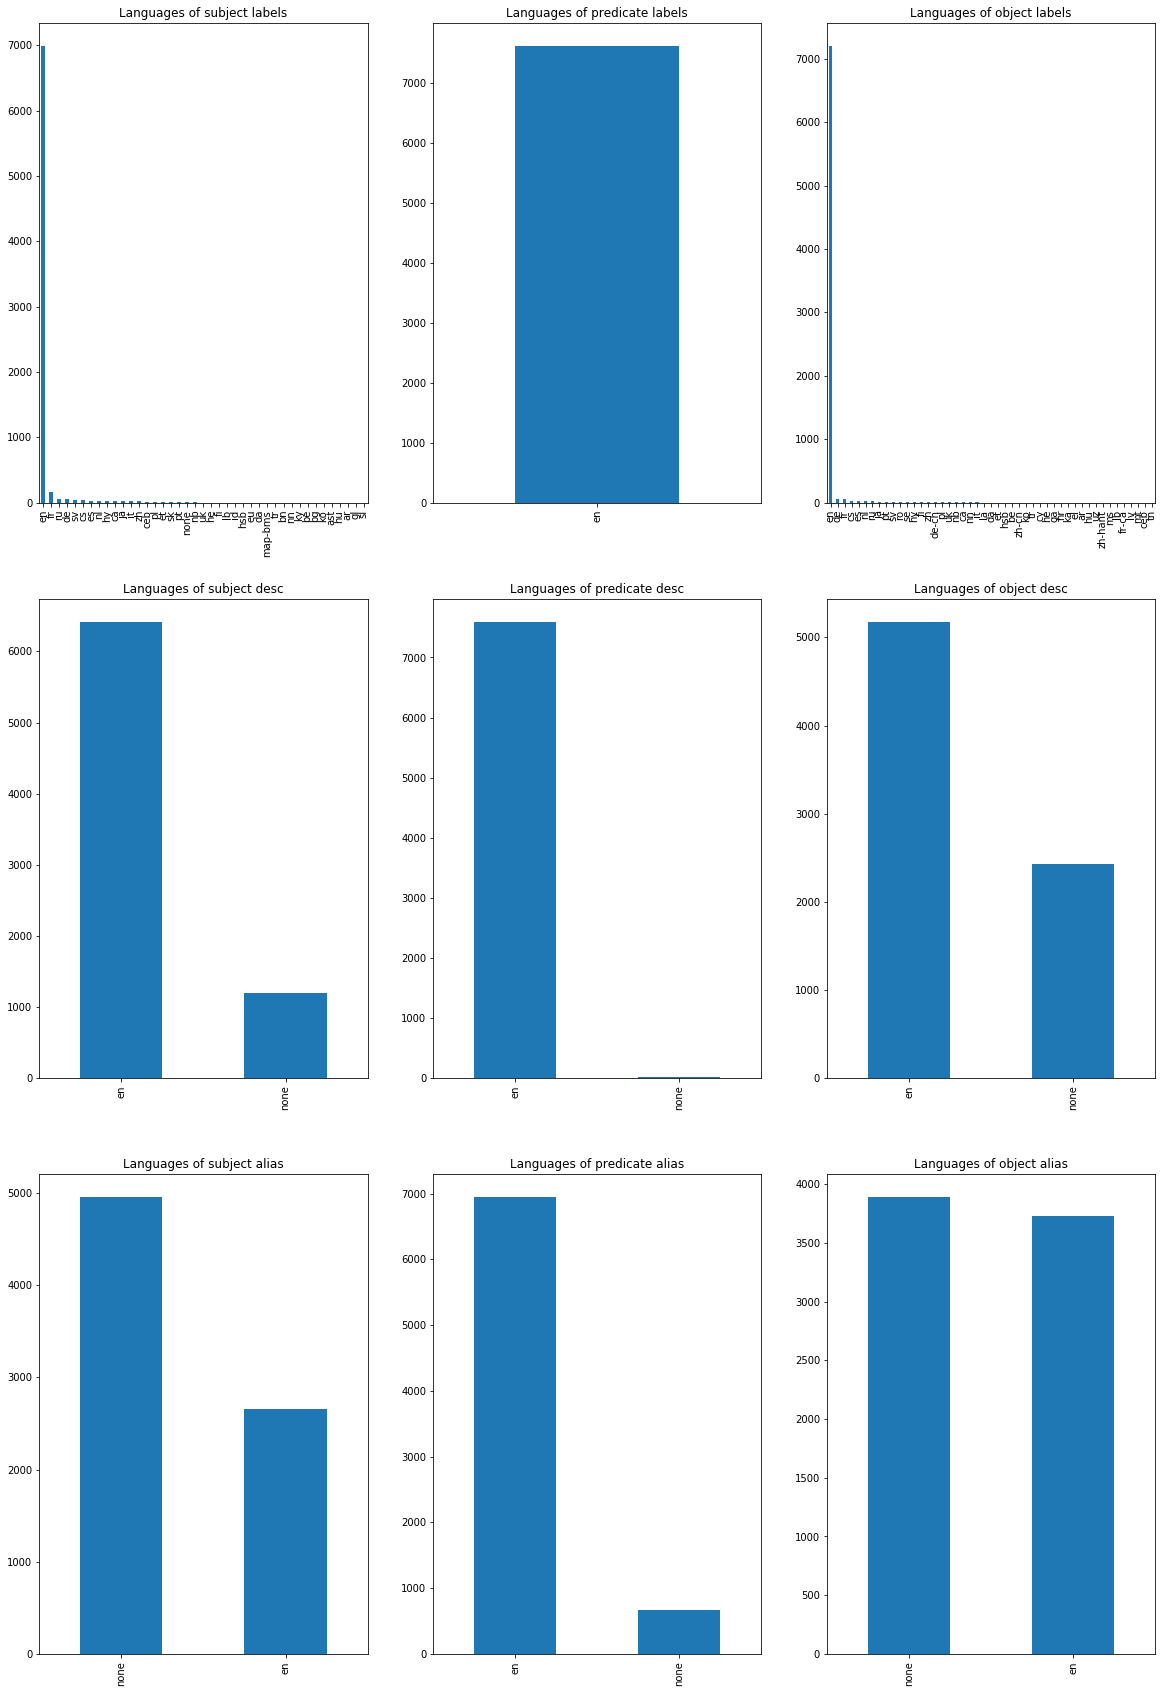

In [186]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(3,3,figsize=(20,30))

sampled_df.entity_label_lan.value_counts().plot(kind='bar', title="Languages of subject labels",ax=ax[0][0])
sampled_df.property_label_lan.value_counts().plot(kind='bar', title="Languages of predicate labels",ax=ax[0][1])
sampled_df.object_label_lan.value_counts().plot(kind='bar', title="Languages of object labels",ax=ax[0][2])

sampled_df.entity_desc_lan.value_counts().plot(kind='bar', title="Languages of subject desc",ax=ax[1][0])
sampled_df.property_desc_lan.value_counts().plot(kind='bar', title="Languages of predicate desc",ax=ax[1][1])
sampled_df.object_desc_lan.value_counts().plot(kind='bar', title="Languages of object desc",ax=ax[1][2])

sampled_df.entity_alias_lan.value_counts().plot(kind='bar', title="Languages of subject alias",ax=ax[2][0])
sampled_df.property_alias_lan.value_counts().plot(kind='bar', title="Languages of predicate alias",ax=ax[2][1])
sampled_df.object_alias_lan.value_counts().plot(kind='bar', title="Languages of object alias",ax=ax[2][2])

plt.show()

In [187]:
sampled_df.to_csv('./data/sampled_df_pre_verbalisation.csv', index=False)